In [ ]:
# CaDRReS: similarity kernel of cell lines (kernel function)
# from CaDRRes-sc
import pandas as pd
import numpy as np
from scipy import stats
import time

def log2_exp(exp_df):
    """Calculate log2 gene expression
    """

    return np.log2(exp_df + 1)

# TODO: add pseudo count for RNA-seq data
def normalize_log2_mean_fc(log2_exp_df):
    """Calculate gene expression fold-change based on median of each genes. The sample size should be large enough (>10).
    """

    return (log2_exp_df.T - log2_exp_df.mean(axis=1)).T, pd.DataFrame(log2_exp_df.mean(axis=1), columns=['median'])

def normalize_log2_mean_fc_with_ref(log2_exp_df, log2_ref_exp_df):
    """Calculate gene expression fold-change based on median of each genes. 
    This should not be used if the data come from different experiments.
    """

    common_genes = set(log2_ref_exp_df.index).intersection(log2_exp_df.index)
    log2_exp_df = log2_exp_df.loc[common_genes]
    log2_ref_exp_df = log2_ref_exp_df.loc[common_genes]

    return (log2_exp_df.T - log2_ref_exp_df.mean(axis=1)).T, pd.DataFrame(log2_ref_exp_df.mean(axis=1), columns=['median'])

def normalize_L1000_suite():
    """
    """

# TODO: make this run in parallel
def calculate_kernel_feature(log2_median_fc_exp_df, ref_log2_median_fc_exp_df, gene_list):
    common_genes = [g for g in gene_list if (g in log2_median_fc_exp_df.index) and (g in ref_log2_median_fc_exp_df.index)]
    
    print ('Calculating kernel features based on', len(common_genes), 'common genes')

    print (log2_median_fc_exp_df.shape, ref_log2_median_fc_exp_df.shape)
    
    sample_list = list(log2_median_fc_exp_df.columns)
    ref_sample_list = list(ref_log2_median_fc_exp_df.columns)

    exp_mat = np.array(log2_median_fc_exp_df.loc[common_genes], dtype='float')
    ref_exp_mat = np.array(ref_log2_median_fc_exp_df.loc[common_genes], dtype='float')

    sim_mat = np.zeros((len(sample_list), len(ref_sample_list)))

    start = time.time()
    for i in range(len(sample_list)):
        if (i+1)%100 == 0:
            print ("{} of {} ({:.2f})s".format(i+1, len(sample_list), time.time()-start))
            start = time.time()
        for j in range(len(ref_sample_list)):
            p_cor, _ = stats.pearsonr(exp_mat[:,i], ref_exp_mat[:,j])
            sim_mat[i, j] = p_cor

    return pd.DataFrame(sim_mat, columns=ref_sample_list, index=sample_list)


In [ ]:
# CaDRReS: similarity kernel of cell lines (compute kernel)
import pandas as pd
ccle_exp = pd.read_csv("/volume/yihyun/drug/CCLE_expression.csv", index_col = 0)
col_name = []
for name in list(ccle_exp.columns):
    col_name.append(name.split(" ")[0])
ccle_exp.columns = col_name
## feature genes (n = 8087)
with open ("/volume/yihyun/drug/MF_model/feature_genes.txt", "r") as f:
    feature_genes = f.read().split("\n")

log_feature_exp = np.log2(ccle_exp + 1).T
logFC_exp = (log_feature_exp.T - log_feature_exp.mean(axis=1)).T
kernel_train = calculate_kernel_feature(logFC_exp,logFC_exp,feature_genes)
kernel_train.to_csv("/volume/yihyun/drug/MF_model/kernel_cl_train.csv", index = True)

In [20]:
# CaDRReS: similarity kernel of cell lines (import pre-computed kernel)
import pandas as pd
import numpy as np
with open ("/volume/yihyun/drug/baseline_model/data/dose_range_mol.txt", "r") as f:
    dose_range_mol = f.read().split("\n")
all_kernel = pd.read_csv("/volume/yihyun/drug/MF_model/kernel_cl_train.csv", index_col = 0)
prism_train = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_train.csv", index_col = 'smiles')
train_mol = np.array(set(dose_range_mol)& set(prism_train.index))
prism_train = prism_train.loc[train_mol]
prism_test = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_test.csv", index_col = 'smiles')
test_mol = np.array(set(dose_range_mol)& set(prism_test.index))
prism_test = prism_test.loc[test_mol]
prism_test_cl = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_test_scdrug.csv", index_col = 'smiles')
prism_test_cl = prism_test_cl.loc[train_mol]

train_kernel = all_kernel.loc[prism_train.columns, prism_train.columns]
# kernel feature based only on training samples
cell_line_sample_list = prism_train.columns.tolist()
X_train = train_kernel.loc[cell_line_sample_list, cell_line_sample_list]
# observed drug response
Y_train = prism_train.T.loc[cell_line_sample_list]
#Y_train = pd.concat([prism_train, prism_test], join='inner').T.loc[cell_line_sample_list]
print(Y_train.shape)

(452, 1225)


In [4]:
# drug/cell line similarity
# from CaDRReS-Sc/model.py
import pandas as pd
import numpy as np
import os, pickle, time

import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
from tensorflow.python.framework import ops
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

def load_model(model_fname):

    """Load a pre-trained model
	:param model_fname: File name of the model
	:return: model_dict contains model information
    """

    model_dict = pickle.load(open(model_fname, 'br'))

    return model_dict


# def get_model_param(pg_space):

    """Get model paramters
    """

# def get_training_info(pg_space):

    """Get training information
    """

def predict_from_model(model_dict, test_kernel_df, model_spec_name='cadrres-wo-sample-bias'):

    """Make a prediction of testing samples. Only for the model without sample bias.
    """

    # TODO: add other model types and update the scrip accordingly
    if model_spec_name not in ['cadrres-wo-sample-bias', 'cadrres-wo-sample-bias-weight']:
        return None

    sample_list = list(test_kernel_df.index)
    
    # Read drug list from model_dict
    drug_list = model_dict['drug_list']
    kernel_sample_list = model_dict['kernel_sample_list']

    # Prepare input
    X = np.matrix(test_kernel_df[kernel_sample_list])

    # Make a prediction
    b_q = model_dict['b_Q']
    WP = model_dict['W_P']
    WQ = model_dict['W_Q']

    n_dim = WP.shape[1]

    pred = b_q.T + (X * WP) * WQ.T
    pred = (pred+80)/240 # convert sensitivity score to IC50
    pred_df = pd.DataFrame(pred, sample_list, drug_list)

    # Projections
    P_test = X * WP
    P_test_df = pd.DataFrame(P_test, index=sample_list, columns=range(1,n_dim+1))  
    
    return pred_df, P_test_df

def calculate_baseline_prediction(obs_resp_df, train_sample_list, drug_list, test_sample_list):

    """Calculate baseline prediction, i.e., for each drug, predict the average response.
    """

    repeated_val = np.repeat([obs_resp_df.loc[train_sample_list, drug_list].mean().values], len(test_sample_list), axis=0)
    return pd.DataFrame(repeated_val, index=test_sample_list, columns=drug_list)


##########################
##### Model training #####
##########################

##### Utility functions #####

def create_placeholders(n_x_features, n_y_features, sample_weight=False):

    """
    Create placeholders for model inputs
    """

    # gene expression
    X = tf.placeholder(tf.float32, [None, n_x_features])
    # drug response
    Y = tf.placeholder(tf.float32, [None, n_y_features])
    if sample_weight:
        # for logistic weight based on maximum drug dosage
        O = tf.placeholder(tf.float32, [None, None])
        # for indication-specific weight
        D = tf.placeholder(tf.float32, [None, None])
        return X, Y, O, D
    else:
        return X, Y

def initialize_parameters(n_samples, n_drugs, n_x_features, n_y_features, n_dimensions, seed):

    """
    Initialize parameters
    Depending on the objective function, b_P might not be used in the later step.
    """

    parameters = {}

    parameters['W_P'] = tf.Variable(tf.truncated_normal([n_x_features, n_dimensions], stddev=0.2, mean=0, seed=seed), name="W_P")
    parameters['W_Q'] = tf.Variable(tf.truncated_normal([n_y_features, n_dimensions], stddev=0.2, mean=0, seed=seed), name="W_Q")
    parameters['b_P'] = tf.get_variable('b_P', [n_samples, 1], initializer = tf.zeros_initializer())
    parameters['b_Q'] = tf.get_variable('b_Q', [n_drugs, 1], initializer = tf.zeros_initializer())

    return parameters

def inward_propagation(X, Y, parameters, n_samples, n_drugs, model_spec_name):

    """
    Define base objective function
    """

    W_P = parameters['W_P']
    W_Q = parameters['W_Q']
    P = tf.matmul(X, W_P)
    Q = tf.matmul(Y, W_Q)

    b_P_mat = tf.matmul(parameters['b_P'], tf.convert_to_tensor(np.ones(n_drugs).reshape(1, n_drugs), np.float32))
    b_Q_mat = tf.transpose(tf.matmul(parameters['b_Q'], tf.convert_to_tensor(np.ones(n_samples).reshape(1, n_samples), np.float32)))

    if model_spec_name == 'cadrres':
        S = tf.add(b_Q_mat, tf.add(b_P_mat, tf.matmul(P, tf.transpose(Q))))
    elif model_spec_name in ['cadrres-wo-sample-bias', 'cadrres-wo-sample-bias-weight']:
        S = tf.add(b_Q_mat, tf.matmul(P, tf.transpose(Q)))
    # TODO: add the model without both drug and sample biases
    # elif model_spec_name == 'cadrres-wo-bias':
    #     S = tf.matmul(P, tf.transpose(Q))
    else:
        S = None

    return S

def get_latent_vectors(X, Y, parameters):

    """
    Get latent vectors of cell line (P) and drug (Q) on the pharmacogenomic space
    """

    W_P = parameters['W_P']
    W_Q = parameters['W_Q']
    P = tf.matmul(X, W_P)
    Q = tf.matmul(Y, W_Q)
    return P, Q

##### Predicting function #####

def predict(X, Y, S_obs, parameters_trained, X_sample_list, model_spec_name, is_train):

    """
    Make a prediction and calculate cost. This function is used in the training step.
    """

    n_samples = len(X_sample_list)
    n_drugs = Y.shape[1]
    
    W_P = parameters_trained['W_P']
    W_Q = parameters_trained['W_Q']
    P = np.matmul(X, W_P)
    Q = np.matmul(Y, W_Q)

    if model_spec_name in ['cadrres-wo-sample-bias', 'cadrres-wo-sample-bias-weight']:
    
        b_Q = parameters_trained['b_Q']

        b_Q_mat = np.transpose(np.matmul(b_Q, np.ones(n_samples).reshape(1, n_samples)))
        S = b_Q_mat + np.matmul(P, np.transpose(Q))

        cost = np.nanmean(np.square(S - S_obs))/2.0

    elif model_spec_name == 'cadrres':
 
        b_Q = parameters_trained['b_Q']
        b_P = parameters_trained['b_P']

        if is_train:

            b_P_est = b_P

        else:
            # estimate sample bias
            b_P_est = np.matmul(X, b_P) 
            # copy bias for seen samples
            for u, s_name in enumerate(X_sample_list):
                if s_name in parameters_trained['sample_list_train']:
                    s_idx = parameters_trained['sample_list_train'].tolist().index(s_name)
                    b_P_est[u, 0] = b_P[s_idx, 0]

        b_P_mat = np.matmul(b_P_est, np.ones(n_drugs).reshape(1, n_drugs))
        b_Q_mat = np.transpose(np.matmul(b_Q, np.ones(n_samples).reshape(1, n_samples)))
        S = b_Q_mat + b_P_mat + np.matmul(P, np.transpose(Q))        

        cost = np.nanmean(np.square(S - S_obs))/2.0

    return S, cost

##### Training function #####

def train_model(train_resp_df, train_feature_df, test_resp_df, test_feature_df, n_dim, lda, max_iter, l_rate, model_spec_name='cadrres-wo-sample-bias', seed=1, save_interval=1000, output_dir='output'):

    """
    Train a model. This is for the original cadrres and cadrres-wo-sample-bias
    :param train_resp_df: drug response training data
    :param train_feature_df: kernel feature training data
    :param test_resp_df: drug response testing data
    :param test_feature_df: kernel feature testing data
    :param n_dim: number of dimension of the latent space
    :param lda: regularization factor
    :param max_iter: maximum iteration
    :param l_rate: learning rate
    :param model_spec_name: model specification to define an objective function
    :param flip_score: if `True` then multiple by -1. This is used for converting IC50 to sensitivity score.
    :param seed: random seed for parameter initialization
    :param save_interval: interval for saving results
    :param output_dir: output directory
    :returns: `parameters_trained` contains trained paramters and `output_dict` contains predictions
    """

    print ('Initializing the model ...')

    # Reset TensorFlow graph
    ops.reset_default_graph()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # TODO: save the model configuration

    ################################
    ##### Setting up the model #####
    ################################

    # TODO: add other model types and update the scrip accordingly
    if model_spec_name not in ['cadrres', 'cadrres-wo-sample-bias']:
        return None

    n_drugs = train_resp_df.shape[1]
    drug_list = train_resp_df.columns

    n_samples = train_resp_df.shape[0]
    sample_list_train = train_resp_df.index
    sample_list_test = test_resp_df.index

    n_x_features = train_feature_df.shape[1]
    n_y_features = n_drugs

    X_train_dat = np.array(train_feature_df)
    Y_train_dat = np.identity(n_drugs)

    X_test_dat = np.array(test_feature_df)
    Y_test_dat = np.identity(n_drugs)

    ##### Scale (1-auc) value #####
    S_train_obs = np.array(train_resp_df) * 240 - 80
    S_test_obs = np.array(test_resp_df) * 240 - 80

    ##### Convert log(IC50) to sensitivity scores #####
    #if flip_score:
    #    S_train_obs = np.array(train_resp_df) * -1
    #    S_test_obs = np.array(test_resp_df) * -1
    #else:
    #    S_train_obs = np.array(train_resp_df)
    #    S_test_obs = np.array(test_resp_df)

    ##### Initialize placeholders and parameters #####
    X_train, Y_train = create_placeholders(n_x_features, n_y_features)
    parameters = initialize_parameters(n_samples, n_drugs, n_x_features, n_y_features, n_dim, seed)

    ##### Extract only prediction of only observed drug response #####
    train_known_idx = np.where(~np.isnan(S_train_obs.reshape(-1)))[0]
    n_train_known = len(train_known_idx)
    print ("Train:", len(train_known_idx), "out of", n_drugs * n_samples)

    S_train_pred = inward_propagation(X_train, Y_train, parameters, n_samples, n_drugs, model_spec_name)
    S_train_pred_resp = tf.gather(tf.reshape(S_train_pred, [-1]), train_known_idx, name="S_train_pred_resp")
    S_train_obs_resp = tf.convert_to_tensor(S_train_obs.reshape(-1)[train_known_idx], np.float32, name="S_train_obs_resp")

    #### Calculate the difference between the predicted sensitivity and the actual #####
    diff_op_train = tf.subtract(S_train_pred_resp, S_train_obs_resp, name="raw_training_error")

    with tf.name_scope("train_cost") as scope:
        base_cost = tf.reduce_sum(tf.square(diff_op_train, name="squared_diff_train"), name="sse_train")
        regularizer = tf.multiply(tf.add(tf.reduce_sum(tf.square(parameters['W_P'])), tf.reduce_sum(tf.square(parameters['W_Q']))), lda, name="regularize")
        cost_train = tf.math.divide(tf.add(base_cost, regularizer), n_train_known * 2.0, name="avg_error_train")

    # TODO: add different kinds of regulalization (the current version uses ridge; see CaDRReS2_tf_matrix_factorization_wo_bp_lasso.py)
    
    ##### Use an exponentially decaying learning rate #####
    # learning_rate = tf.train.exponential_decay(l_rate, global_step, 10000, 0.96, staircase=True)

    ##################################################
    ##### Initialize session and train the model #####
    ##################################################

    print ('Starting model training ...')

    global_step = tf.Variable(0, trainable=False)

    with tf.name_scope("train") as scope:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=l_rate)
        train_step = optimizer.minimize(cost_train, global_step=global_step)
        mse_summary = tf.summary.scalar("mse_train", cost_train)

    sess = tf.Session()

    # TODO: save model every save_interval
    # summary_op = tf.summary.merge_all()
    # writer = tf.summary.FileWriter("{}/tf_matrix_factorization_logs".format(output_dir), sess.graph)

    sess.run(tf.global_variables_initializer())
    parameters_init = sess.run(parameters)

    cost_train_vals = []
    cost_test_vals = []

    start = time.time()
    for i in range(max_iter):    
        _ = sess.run(train_step, feed_dict={X_train: X_train_dat, Y_train: Y_train_dat})
        
        if i % save_interval == 0:

            # training step
            res = sess.run(cost_train, feed_dict={X_train: X_train_dat, Y_train: Y_train_dat})
            cost_train_vals += [res]

            time_used = (time.time() - start)
            print("MSE train at step {}: {:.3f} ({:.2f}m)".format(i, cost_train_vals[-1], time_used/60))

            # save parameter
            parameters_trained = sess.run(parameters)
            parameters_trained['sample_list_train'] = sample_list_train
            parameters_trained['sample_list_test'] = sample_list_test
            # make a prediction
            test_pred, test_cost = predict(X_test_dat, Y_test_dat, S_test_obs, parameters_trained, sample_list_test, model_spec_name, False)

            cost_test_vals += [test_cost]
            # summary_str = res[0]
            # writer.add_summary(summary_str, i)

    parameters_trained, train_pred = sess.run([parameters, S_train_pred], feed_dict={X_train: X_train_dat, Y_train: Y_train_dat})
    parameters_trained['sample_list_train'] = sample_list_train
    parameters_trained['sample_list_test'] = sample_list_test

    test_pred, test_cost = predict(X_test_dat, Y_test_dat, S_test_obs, parameters_trained, sample_list_test, model_spec_name, False)
    train_pred, train_cost = predict(X_train_dat, Y_train_dat, S_train_obs, parameters_trained, sample_list_train, model_spec_name, True)
    parameters_trained['mse_train_vals'] = cost_train_vals
    parameters_trained['mse_test_vals'] = cost_test_vals

    P_train, Q_train = get_latent_vectors(X_train, Y_train, parameters)
    P, Q = sess.run([P_train, Q_train], feed_dict={X_train: X_train_dat, Y_train: Y_train_dat})

    sess.close()

    ############################
    ##### Saving the model #####
    ############################

    print ('Saving model parameters and predictions ...')

    # Save model configurations

    parameters_trained['n_dim'] = n_dim
    parameters_trained['lda'] = lda
    parameters_trained['max_iter'] = max_iter
    parameters_trained['l_rate'] = l_rate
    parameters_trained['model_spec_name'] = model_spec_name
    parameters_trained['seed'] = seed

    parameters_trained['drug_list'] = drug_list
    parameters_trained['train_sample_list'] = sample_list_train
    parameters_trained['kernel_sample_list'] = list(train_feature_df.columns)

    # Save the prediction and processed data

    pred_df = pd.DataFrame(test_pred, index=sample_list_test, columns=drug_list) * -1
    obs_df = pd.DataFrame(S_test_obs, index=sample_list_test, columns=drug_list) * -1

    pred_train_df = pd.DataFrame(train_pred, index=sample_list_train, columns=drug_list) * -1
    obs_train_df = pd.DataFrame(S_train_obs, index=sample_list_train, columns=drug_list) * -1

    output_dict = {}
    output_dict['pred_test_df'] = pred_df
    output_dict['obs_test_df'] = obs_df
    output_dict['pred_train_df'] = pred_train_df
    output_dict['obs_train_df'] = obs_train_df

    bq = parameters_trained['b_Q']
    bq_df = pd.DataFrame([drug_list, list(bq.flatten())]).T
    bq_df.columns = ['drug_name', 'drug_bias']
    bq_df = bq_df.set_index('drug_name')

    P_df = pd.DataFrame(P, index=sample_list_train, columns=range(1, n_dim+1))
    Q_df = pd.DataFrame(Q, index=drug_list, columns=range(1, n_dim+1))

    output_dict['b_Q_df'] = bq_df
    output_dict['P_df'] = P_df
    output_dict['Q_df'] = Q_df

    print ('DONE')

    return parameters_trained, output_dict



def get_sample_weights_logistic_x0(drug_df, log2_max_conc_col_name, sample_list):

    """
    Calculate weights_logistic_x0_df, which is an input of train_model_logistic_weight. The logistic weight is assigned to each drug-sample pair with respect to maximum drug dosage.
    """

    drug_list = drug_df.index
    max_conc = np.array(drug_df[[log2_max_conc_col_name]])
    n_samples = len(sample_list)
    weights_logistic_x0 = np.repeat(max_conc.T, n_samples, axis=0)
    weights_logistic_x0_df = pd.DataFrame(weights_logistic_x0, columns=drug_list, index=sample_list)

    return weights_logistic_x0_df

2023-03-20 11:16:43.850235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 11:16:44.824859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-20 11:16:44.824978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-20 11:16:44.824990: W 

Instructions for updating:
non-resource variables are not supported in the long term


In [21]:
# training CaDRReS (train_mol)
import sys, os, pickle
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
from collections import Counter

import importlib
from ipywidgets import widgets
import warnings
warnings.filterwarnings('ignore')
# specify output directry
output_dir = './result/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print ('Results will be saved in ', output_dir)

indication_weight_df = pd.DataFrame(np.ones(Y_train.shape), index=Y_train.index, columns=Y_train.columns)
obj_function = widgets.Dropdown(options=['cadrres-wo-sample-bias', 'cadrres-wo-sample-bias-weight'], description='Objetice function')
display(obj_function)
cadrres_model_dict, cadrres_output_dict = train_model(Y_train, X_train, Y_train, X_train, 
                                                      10, 0.0, 150000, 0.01, 
                                                      model_spec_name="cadrres-wo-sample-bias", 
                                                      save_interval=5000, output_dir=output_dir)
# save model
model_name = "same_dose_range"
#model_name = "same_dose_range_all"
print('Saving ' + output_dir + '{}_param_dict.pickle'.format("cadrres-wo-sample-bias_CLsim" + model_name))
pickle.dump(cadrres_model_dict, open(output_dir + '{}_param_dict.pickle'.format("cadrres-wo-sample-bias_CLsim" + model_name), 'wb'))
print('Saving ' + output_dir + '{}_output_dict.pickle'.format("cadrres-wo-sample-bias_CLsim" + model_name))
pickle.dump(cadrres_output_dict, open(output_dir + '{}_output_dict.pickle'.format("cadrres-wo-sample-bias_CLsim" + model_name), 'wb'))


Results will be saved in  ./result/


Dropdown(description='Objetice function', options=('cadrres-wo-sample-bias', 'cadrres-wo-sample-bias-weight'),…

Initializing the model ...
Train: 495871 out of 553700
Starting model training ...


2023-03-20 11:45:20.642074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9399 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


MSE train at step 0: 2009.252 (0.01m)
MSE train at step 5000: 216.367 (0.56m)
MSE train at step 10000: 185.965 (0.99m)
MSE train at step 15000: 173.924 (1.43m)
MSE train at step 20000: 166.741 (1.96m)
MSE train at step 25000: 161.279 (2.41m)
MSE train at step 30000: 157.302 (2.84m)
MSE train at step 35000: 154.339 (3.37m)
MSE train at step 40000: 151.889 (3.78m)
MSE train at step 45000: 149.743 (4.21m)
MSE train at step 50000: 147.852 (4.74m)
MSE train at step 55000: 146.182 (5.18m)
MSE train at step 60000: 144.680 (5.61m)
MSE train at step 65000: 143.303 (6.18m)
MSE train at step 70000: 142.026 (6.62m)
MSE train at step 75000: 140.834 (7.06m)
MSE train at step 80000: 139.717 (7.59m)
MSE train at step 85000: 138.666 (7.97m)
MSE train at step 90000: 137.677 (8.39m)
MSE train at step 95000: 136.746 (8.87m)
MSE train at step 100000: 135.868 (9.28m)
MSE train at step 105000: 135.040 (9.67m)
MSE train at step 110000: 134.260 (10.22m)
MSE train at step 115000: 133.525 (10.64m)
MSE train at s

In [22]:
# loading model
model_name = "same_dose_range"
model_spec_name = "cadrres-wo-sample-bias_CLsim"

model_dir = "/volume/yihyun/drug/combined_model/result/"
model_file = model_dir + '{}_param_dict.pickle'.format(model_spec_name + model_name)
cadrres_model = load_model(model_file)
print('Predicting drug response using CaDRReS: {}'.format(model_spec_name))
train_cl = prism_train.columns.tolist()
test_cl = prism_test_cl.columns.tolist()
test_kernel = all_kernel.loc[train_cl+test_cl, train_cl+test_cl]
pred_df, P_test_df= predict_from_model(cadrres_model, test_kernel, "cadrres-wo-sample-bias")
pred_df.T.to_csv("/volume/yihyun/drug/combined_model/result/cadrres_CLsim_testCL_sameDRmol_pred.csv", index = True)
print('done!')

Predicting drug response using CaDRReS: cadrres-wo-sample-bias_CLsim
done!


In [26]:
# training CaDRReS-SVM
from sklearn import svm
from rdkit import Chem
import rdkit
import numpy as np
import pandas as pd
prism_train = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_train.csv", index_col = 'smiles')
train_mol = np.array(set(dose_range_mol)& set(prism_train.index))
prism_train = prism_train.loc[train_mol]
prism_test = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_test.csv", index_col = 'smiles')
test_mol = np.array(set(dose_range_mol)& set(prism_test.index))
prism_test = prism_test.loc[test_mol]
prism_test_cl = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_test_scdrug.csv", index_col = 'smiles')
prism_test_cl = prism_test_cl.loc[train_mol]
prism_both = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_disjoint_test.csv", index_col='smiles')
prism_both = prism_both.loc[test_mol]
cadrres_pred = pd.read_csv("/volume/yihyun/drug/combined_model/result/cadrres_CLsim_testCL_sameDRmol_pred.csv", index_col='smiles')

# convert smiles encoding to fingerprints
## train
train_mol = prism_train.index.tolist()
train_mol_rdkit = list(map(Chem.MolFromSmiles,train_mol))
train_fps = [list(map(int, list(Chem.RDKFingerprint(x).ToBitString()))) for x in train_mol_rdkit]
train_fps = np.array(train_fps)
## test
test_mol = prism_both.index.tolist()
test_mol_rdkit = list(map(Chem.MolFromSmiles,test_mol))
test_fps = [list(map(int, list(Chem.RDKFingerprint(x).ToBitString()))) for x in test_mol_rdkit]
test_fps = np.array(test_fps)
test_cl = prism_both.columns.tolist()

# evaluation result
result = np.empty((len(test_mol), len(test_cl)))
result[:] = np.nan
result_df = pd.DataFrame(result, columns=test_cl, index = test_mol)

for cell_line in test_cl:
     print(cell_line)
     train_auc = np.array([auc if auc>=0 else 0 for auc in cadrres_pred[cell_line]])
     train_auc = np.array([auc if auc <=1 else 1 for auc in train_auc])
     train_auc

     X = train_fps
     y = train_auc
     model = svm.SVR()
     model.fit(X, y)

     pred_y = model.predict(test_fps)
     result_df.loc[:, cell_line] = pred_y
result_df.to_csv("/volume/yihyun/drug/combined_model/result/cadrres_svm_test_both_sameDRmol.csv", index = True)

ACH-000123
ACH-000189
ACH-000209
ACH-000228
ACH-000244
ACH-000252
ACH-000288
ACH-000329
ACH-000367
ACH-000397
ACH-000415
ACH-000423
ACH-000553
ACH-000565
ACH-000672
ACH-000713
ACH-000717
ACH-000764
ACH-000791
ACH-000834
ACH-000875
ACH-000927
ACH-000977
ACH-001190


In [30]:
# training SVM
from sklearn.model_selection import LeaveOneOut
from sklearn import svm
from rdkit import Chem
import rdkit
import numpy as np
import pandas as pd

prism_train = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_train.csv", index_col = 'smiles')
train_mol = np.array(set(dose_range_mol)& set(prism_train.index))
prism_train = prism_train.loc[train_mol]
prism_test = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_test.csv", index_col = 'smiles')
test_mol = np.array(set(dose_range_mol)& set(prism_test.index))
prism_test = prism_test.loc[test_mol]
prism_test_cl = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_test_scdrug.csv", index_col = 'smiles')
prism_test_cl = prism_test_cl.loc[train_mol]
prism_both = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_test_molGNN_scdrug.csv", index_col='smiles')
prism_both = prism_both.loc[test_mol]

# convert smiles encoding to fingerprints
## test
test_mol = prism_both.index.tolist()
test_mol_rdkit = list(map(Chem.MolFromSmiles,test_mol))
test_fps = [list(map(int, list(Chem.RDKFingerprint(x).ToBitString()))) for x in test_mol_rdkit]
test_fps = np.array(test_fps)
test_cl = prism_both.columns.tolist()

# evaluation result
result = np.empty((len(test_mol), len(test_cl)))
result[:] = np.nan
result_df = pd.DataFrame(result, columns=test_cl, index = test_mol)

for cell_line in test_cl:
     print(cell_line)
     #train_auc = np.array([auc if auc>=0 else 0 for auc in cadrres_pred[cell_line]])
     #train_auc = np.array([auc if auc <=1 else 1 for auc in train_auc])
     tmp = prism_test_cl[cell_line].dropna()
     train_auc = np.array(tmp)

     ## train
     train_mol = tmp.index.tolist()
     train_mol_rdkit = list(map(Chem.MolFromSmiles,train_mol))
     train_fps = [list(map(int, list(Chem.RDKFingerprint(x).ToBitString()))) for x in train_mol_rdkit]
     train_fps = np.array(train_fps)

     X = train_fps
     y = train_auc
     model = svm.SVR()
     model.fit(X, y)

     pred_y = model.predict(test_fps)
     result_df.loc[:, cell_line] = pred_y
result_df.to_csv("/volume/yihyun/drug/combined_model/result/svm_test_both_sameDRmol.csv", index = True)

ACH-000123
ACH-000189
ACH-000209
ACH-000228
ACH-000244
ACH-000252
ACH-000288
ACH-000329
ACH-000367
ACH-000397
ACH-000415
ACH-000423
ACH-000553
ACH-000565
ACH-000672
ACH-000713
ACH-000717
ACH-000764
ACH-000791
ACH-000834
ACH-000875
ACH-000927
ACH-000977
ACH-001190


In [ ]:
# training CaDRReS (train_mol+test_mol)
import pandas as pd
import numpy as np
with open ("/volume/yihyun/drug/baseline_model/data/dose_range_mol.txt", "r") as f:
    dose_range_mol = f.read().split("\n")
all_kernel = pd.read_csv("/volume/yihyun/drug/MF_model/kernel_cl_train.csv", index_col = 0)
prism_train = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_train.csv", index_col = 'smiles')
train_mol = np.array(set(dose_range_mol)& set(prism_train.index))
prism_train = prism_train.loc[train_mol]
prism_test = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_test.csv", index_col = 'smiles')
test_mol = np.array(set(dose_range_mol)& set(prism_test.index))
prism_test = prism_test.loc[test_mol]
prism_test_cl = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_test_scdrug.csv", index_col = 'smiles')
prism_test_cl = prism_test_cl.loc[train_mol]

train_kernel = all_kernel.loc[prism_train.columns, prism_train.columns]
# kernel feature based only on training samples
cell_line_sample_list = prism_train.columns.tolist()
X_train = train_kernel.loc[cell_line_sample_list, cell_line_sample_list]
# observed drug response
#Y_train = prism_train.T.loc[cell_line_sample_list]
Y_train = pd.concat([prism_train, prism_test], join='inner').T.loc[cell_line_sample_list]
print(Y_train.shape)


import sys, os, pickle
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
from collections import Counter

import importlib
from ipywidgets import widgets
import warnings
warnings.filterwarnings('ignore')
# specify output directry
output_dir = '/volume/yihyun/drug/combined_model/result/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print ('Results will be saved in ', output_dir)

indication_weight_df = pd.DataFrame(np.ones(Y_train.shape), index=Y_train.index, columns=Y_train.columns)
obj_function = widgets.Dropdown(options=['cadrres-wo-sample-bias', 'cadrres-wo-sample-bias-weight'], description='Objetice function')
display(obj_function)
cadrres_model_dict, cadrres_output_dict = train_model(Y_train, X_train, Y_train, X_train, 
                                                      10, 0.0, 150000, 0.01, 
                                                      model_spec_name="cadrres-wo-sample-bias", 
                                                      save_interval=5000, output_dir=output_dir)
# save model
#model_name = "same_dose_range"
model_name = "same_dose_range_all"
print('Saving ' + output_dir + '{}_param_dict.pickle'.format("cadrres-wo-sample-bias_CLsim" + model_name))
pickle.dump(cadrres_model_dict, open(output_dir + '{}_param_dict.pickle'.format("cadrres-wo-sample-bias_CLsim" + model_name), 'wb'))
print('Saving ' + output_dir + '{}_output_dict.pickle'.format("cadrres-wo-sample-bias_CLsim" + model_name))
pickle.dump(cadrres_output_dict, open(output_dir + '{}_output_dict.pickle'.format("cadrres-wo-sample-bias_CLsim" + model_name), 'wb'))


In [ ]:
# loading model
model_name = "same_dose_range_all"
model_spec_name = "cadrres-wo-sample-bias_CLsim"

model_dir = "/volume/yihyun/drug/combined_model/result/"
model_file = model_dir + '{}_param_dict.pickle'.format(model_spec_name + model_name)
cadrres_model = load_model(model_file)
print('Predicting drug response using CaDRReS: {}'.format(model_spec_name))
train_cl = prism_train.columns.tolist()
test_cl = prism_test_cl.columns.tolist()
test_kernel = all_kernel.loc[train_cl+test_cl, train_cl+test_cl]
pred_df, P_test_df= predict_from_model(cadrres_model, test_kernel, "cadrres-wo-sample-bias")
pred_df.T.to_csv("/volume/yihyun/drug/combined_model/result/cadrres_CLsim_testCL_sameDRmol_all_pred.csv", index = True)
print('done!')

In [28]:
# evaluation function
def masked_aCC(pred, label, mask):
    # multi-output average correlation coefficient with masking
    d_label = (label - np.nansum(label,1)/np.sum(mask, 1))
    d_pred = (pred - np.nansum(pred,1)/np.sum(mask, 1))
    x = np.nansum(np.multiply(d_label,d_pred), 1)
    y = np.sqrt(np.multiply(np.nansum(np.square(d_label), 1) , np.nansum(np.square(d_pred), 1)))
    #aCC = np.mean(x/y)
    return x/y
def masked_mse(pred, label, mask):
    # multi-output mse with masking
    return np.nansum(np.array(pred-label)**2, 1)/np.sum(np.array(mask),1)

In [56]:
import pandas as pd
import numpy as np
with open ("/volume/yihyun/drug/baseline_model/data/dose_range_mol.txt", "r") as f:
    dose_range_mol = f.read().split("\n")
prism_both = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_disjoint_test.csv", index_col='smiles')
test_mol = np.array(set(dose_range_mol) & set(prism_both.index))
prism_both = prism_both.loc[test_mol,test_cl]
test_cl = prism_both.columns.to_list()
cadrres_pred = pd.read_csv("/volume/yihyun/drug/combined_model/result/cadrres_CLsim_testCL_sameDRmol_all_pred.csv", index_col = 0)
cadrres_pred = cadrres_pred.loc[test_mol, test_cl]
cadrres_svm_pred = pd.read_csv("/volume/yihyun/drug/combined_model/result/cadrres_svm_test_both_sameDRmol.csv", index_col = 0)
cadrres_svm_pred = cadrres_svm_pred.loc[test_mol, test_cl]
svm_pred = pd.read_csv("/volume/yihyun/drug/combined_model/result/svm_test_both_sameDRmol.csv", index_col = 0)
svm_pred = svm_pred.loc[test_mol, test_cl]

pred_cadrres = np.matrix(cadrres_pred)
pred_cadrres_svm = np.matrix(cadrres_svm_pred)
pred_svm = np.matrix(svm_pred)
label = np.matrix(prism_both)
mask = np.matrix(np.isnan(prism_both)==False, dtype=int)

0.8089526937457295
0.38983795564912455
0.4251156988175587
0.008365554796684029
0.026198271644555068
0.020640572598235284


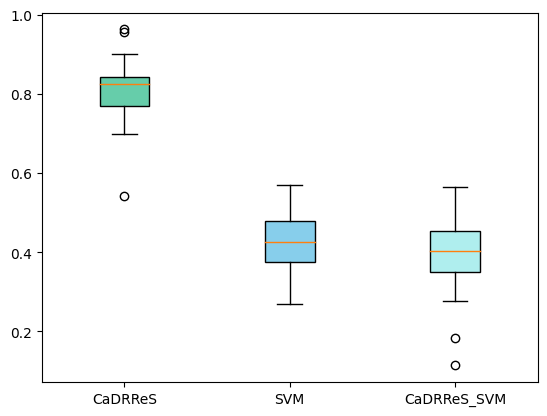

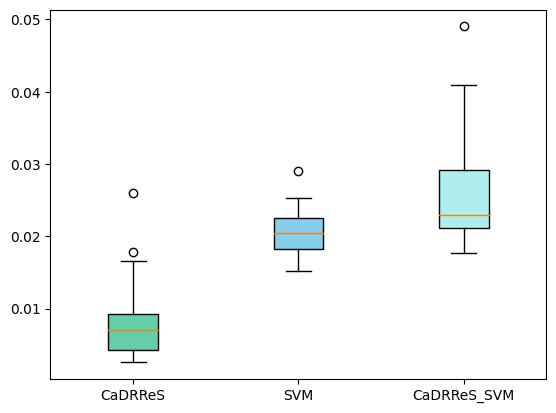

0.15892232224469188
0.13476081228431408
0.2396518088466223
0.008599586952065441
0.02689275593295591
0.021296177816147722


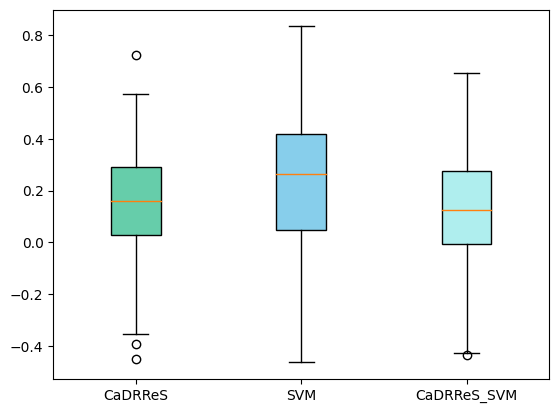

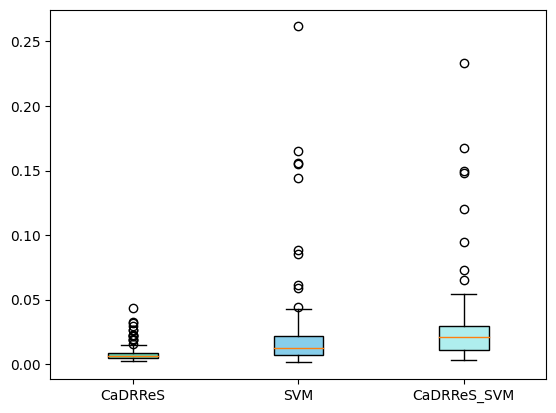

In [57]:
# evaluation
import matplotlib.pyplot as plt
### cell-wise
pcc_cadrres = masked_aCC(pred_cadrres.T, label.T, mask.T)
pcc_cadrres = [p for p in pcc_cadrres if np.isnan(p) == False]
print(np.mean(pcc_cadrres))
pcc_cadrres_svm = masked_aCC(pred_cadrres_svm.T, label.T, mask.T)
pcc_cadrres_svm = [p for p in pcc_cadrres_svm if np.isnan(p) == False]
print(np.mean(pcc_cadrres_svm))
pcc_svm = masked_aCC(pred_svm.T, label.T, mask.T)
pcc_svm = [p for p in pcc_svm if np.isnan(p) == False]
print(np.mean(pcc_svm))

mse_cadrres = masked_mse(pred_cadrres.T, label.T, mask.T)
mse_cadrres = [e for e in mse_cadrres if np.isnan(e) == False]
print(np.mean(mse_cadrres))
mse_cadrres_svm = masked_mse(pred_cadrres_svm.T, label.T, mask.T)
mse_cadrres_svm = [e for e in mse_cadrres_svm if np.isnan(e) == False]
print(np.mean(mse_cadrres_svm))
mse_svm = masked_mse(pred_svm.T, label.T, mask.T)
mse_svm = [e for e in mse_svm if np.isnan(e) == False]
print(np.mean(mse_svm))

colors_dict={"SVM": "skyblue", "CaDRReS": "mediumaquamarine",
             "CaDRReS_SVM":"paleturquoise"}
#### cell-wise_pcc
pred_dict = {'CaDRReS': np.array(pcc_cadrres).flatten(),
            'SVM': np.array(pcc_svm).flatten(),
            'CaDRReS_SVM': np.array(pcc_cadrres_svm).flatten(),
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()
#### cell-wise_mse
pred_dict = {'CaDRReS': np.array(mse_cadrres).flatten(),
             'SVM': np.array(mse_svm).flatten(),
            'CaDRReS_SVM': np.array(mse_cadrres_svm).flatten(),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

### drug-wise
pcc_cadrres = masked_aCC(pred_cadrres, label, mask)
pcc_cadrres = [p for p in pcc_cadrres if np.isnan(p) == False]
print(np.mean(pcc_cadrres))
pcc_cadrres_svm = masked_aCC(pred_cadrres_svm, label, mask)
pcc_cadrres_svm = [p for p in pcc_cadrres_svm if np.isnan(p) == False]
print(np.mean(pcc_cadrres_svm))
pcc_svm = masked_aCC(pred_svm, label, mask)
pcc_svm = [p for p in pcc_svm if np.isnan(p) == False]
print(np.mean(pcc_svm))

mse_cadrres = masked_mse(pred_cadrres, label, mask)
mse_cadrres = [e for e in mse_cadrres if np.isnan(e) == False]
print(np.mean(mse_cadrres))
mse_cadrres_svm = masked_mse(pred_cadrres_svm, label, mask)
mse_cadrres_svm = [e for e in mse_cadrres_svm if np.isnan(e) == False]
print(np.mean(mse_cadrres_svm))
mse_svm = masked_mse(pred_svm, label, mask)
mse_svm = [e for e in mse_svm if np.isnan(e) == False]
print(np.mean(mse_svm))

#### drug-wise_pcc
pred_dict = {'CaDRReS': np.array(pcc_cadrres).flatten(),
            'SVM': np.array(pcc_svm).flatten(),
            'CaDRReS_SVM': np.array(pcc_cadrres_svm).flatten(),
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()
#### drug-wise_mse
pred_dict = {'CaDRReS': np.array(mse_cadrres).flatten(),
            'SVM': np.array(mse_svm).flatten(),
            'CaDRReS_SVM': np.array(mse_cadrres_svm).flatten(),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

0.7968888836573939
0.28430039732173656
0.27659311875100184


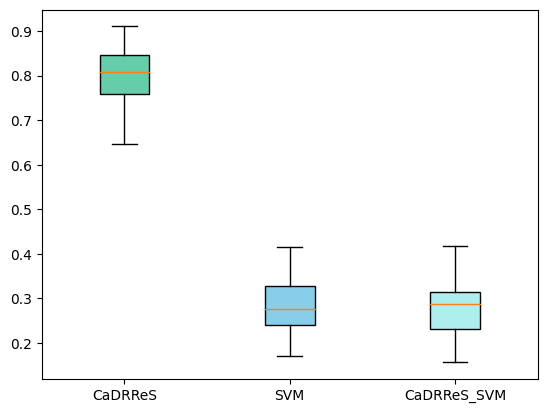

In [86]:
# cell-wise SCC
from scipy.stats import spearmanr
# evaluation result
cadrres_svm_scc_result = []
for cell_line in test_cl:
    tmp_data = prism_both.loc[test_mol, cell_line].dropna()
    tmp_result = cadrres_svm_pred.loc[tmp_data.index, cell_line]

    # ranking
    #label_rank = np.array(tmp_data.rank(axis=0))
    #pred_rank = np.array(tmp_result.rank(axis=0))

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    cadrres_svm_scc_result.append(scc)

svm_scc_result = []
for cell_line in test_cl:
    tmp_data = prism_both.loc[test_mol, cell_line].dropna()
    tmp_result = svm_pred.loc[tmp_data.index, cell_line]

    # ranking
    #label_rank = np.array(tmp_data.rank(axis=0))
    #pred_rank = np.array(tmp_result.rank(axis=0))

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    svm_scc_result.append(scc)

cadrres_scc_result = []
for cell_line in test_cl:
    tmp_data = prism_both.loc[test_mol, cell_line].dropna()
    tmp_result = cadrres_pred.loc[tmp_data.index, cell_line]

    # ranking
    #label_rank = np.array(tmp_data.rank(axis=0))
    #pred_rank = np.array(tmp_result.rank(axis=0))

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    cadrres_scc_result.append(scc)

print(np.mean(np.array(cadrres_scc_result).flatten()))
print(np.mean(np.array(svm_scc_result).flatten()))
print(np.mean(np.array(cadrres_svm_scc_result).flatten()))
pred_dict = {'CaDRReS': np.array(cadrres_scc_result).flatten(),
            'SVM': np.array(svm_scc_result).flatten(),
            'CaDRReS_SVM': np.array(cadrres_svm_scc_result).flatten(),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

0.11226626878871333
0.2529257217294333
0.06039072228261301


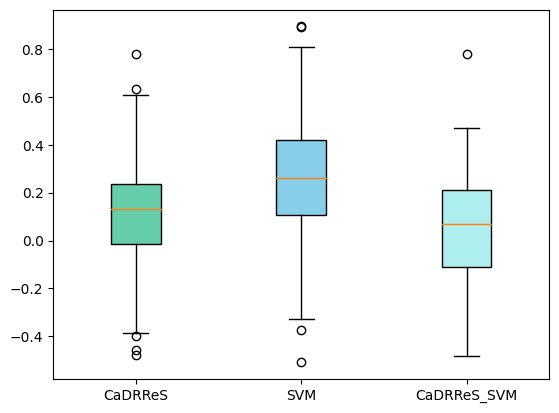

In [85]:
# drug-wise SCC
from scipy.stats import spearmanr
test_mol = list(set(dose_range_mol) & set(prism_both.index))
# evaluation result
cadrres_svm_scc_result = []
for smiles in test_mol:
    tmp_data = prism_both.loc[smiles, test_cl].dropna()
    tmp_result = cadrres_svm_pred.loc[smiles, tmp_data.index]

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    cadrres_svm_scc_result.append(scc)

svm_scc_result = []
for smiles in test_mol:
    tmp_data = prism_both.loc[smiles, test_cl].dropna()
    tmp_result = svm_pred.loc[smiles, tmp_data.index]

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    svm_scc_result.append(scc)

cadrres_scc_result = []
for smiles in test_mol:
    tmp_data = prism_both.loc[smiles, test_cl].dropna()
    tmp_result = cadrres_pred.loc[smiles, tmp_data.index]


    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    cadrres_scc_result.append(scc)

print(np.mean(np.array(np.array(cadrres_scc_result)[np.isnan(cadrres_scc_result) == False]).flatten()))
print(np.mean(np.array(np.array(svm_scc_result)[np.isnan(svm_scc_result) == False]).flatten()))
print(np.mean(np.array(np.array(cadrres_svm_scc_result)[np.isnan(cadrres_svm_scc_result) == False]).flatten()))
pred_dict = {'CaDRReS': np.array(np.array(cadrres_scc_result)[np.isnan(cadrres_scc_result) == False]).flatten(),
            'SVM': np.array(np.array(svm_scc_result)[np.isnan(svm_scc_result) == False]).flatten(),
            'CaDRReS_SVM': np.array(np.array(cadrres_svm_scc_result)[np.isnan(cadrres_svm_scc_result) == False]).flatten(),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [90]:
# external testing (GDSC2)
GDSC2_external = pd.read_csv("/volume/yihyun/drug/GDSC/GDSC2_external_auc.csv", index_col = 0)
ccle = pd.read_csv("/volume/yihyun/drug/CCLE_expression.csv", index_col = 0)
all_kernel = pd.read_csv("/volume/yihyun/drug/MF_model/kernel_cl_train.csv", index_col = 0)
train_cl = prism_train.columns.tolist()
external_test_cl = list(set(ccle.index.tolist()) & set(GDSC2_external.columns.tolist()))
test_kernel = all_kernel.loc[train_cl+GDSC2_external.columns.tolist(), train_cl+GDSC2_external.columns.tolist()]
# loading model
model_name = "same_dose_range"
model_spec_name = "cadrres-wo-sample-bias_CLsim"

model_dir = "/volume/yihyun/drug/combined_model/result/"
model_file = model_dir + '{}_param_dict.pickle'.format(model_spec_name + model_name)
cadrres_model = load_model(model_file)
print('Predicting drug response using CaDRReS: {}'.format(model_spec_name))

pred_df, P_test_df= predict_from_model(cadrres_model, test_kernel, "cadrres-wo-sample-bias")
pred_df.T[external_test_cl].to_csv("/volume/yihyun/drug/combined_model/result/cadrres_GDSC_sameDRmol_pred.csv", index = True)
print('done!')

Predicting drug response using CaDRReS: cadrres-wo-sample-bias_CLsim
done!


In [91]:
# CaDRReS-SVM (external)
from sklearn import svm
from rdkit import Chem
import rdkit
import numpy as np
import pandas as pd

with open ("/volume/yihyun/drug/baseline_model/data/dose_range_mol.txt", "r") as f:
    dose_range_mol = f.read().split("\n")
prism_train = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_train.csv", index_col = 'smiles')
train_mol = np.array(set(dose_range_mol)& set(prism_train.index))
prism_train = prism_train.loc[train_mol]
GDSC2_external = pd.read_csv("/volume/yihyun/drug/GDSC/GDSC2_external_auc.csv", index_col = 0)
cadrres_pred = pd.read_csv("/volume/yihyun/drug/combined_model/result/cadrres_GDSC_sameDRmol_pred.csv", index_col='smiles')
# convert smiles encoding to fingerprints
## train
train_mol = prism_train.index.tolist()
train_mol_rdkit = list(map(Chem.MolFromSmiles,train_mol))
train_fps = [list(map(int, list(Chem.RDKFingerprint(x).ToBitString()))) for x in train_mol_rdkit]
train_fps = np.array(train_fps)
## test
test_mol = GDSC2_external.index.tolist()
test_mol_rdkit = list(map(Chem.MolFromSmiles,test_mol))
test_fps = [list(map(int, list(Chem.RDKFingerprint(x).ToBitString()))) for x in test_mol_rdkit]
test_fps = np.array(test_fps)
test_cl = cadrres_pred.columns.tolist()

# evaluation result
result = np.empty((len(test_mol), len(test_cl)))
result[:] = np.nan
result_df = pd.DataFrame(result, columns=test_cl, index = test_mol)

for cell_line in test_cl:
     print(cell_line)
     train_auc = np.array([auc if auc>=0 else 0 for auc in cadrres_pred[cell_line]])
     train_auc = np.array([auc if auc <=1 else 1 for auc in train_auc])

     X = train_fps
     y = train_auc
     model = svm.SVR()
     model.fit(X, y)

     pred_y = model.predict(test_fps)
     result_df.loc[:, cell_line] = pred_y

result_df[external_test_cl].to_csv("/volume/yihyun/drug/GDSC/cadrres_svm_test_external_sameDRmol.csv", index = True)

ACH-000090
ACH-000592
ACH-000696
ACH-000467
ACH-000261
ACH-000137
ACH-000018
ACH-000906
ACH-000242
ACH-000898
ACH-000141
ACH-000322
ACH-000332
ACH-001239
ACH-000605
ACH-000643
ACH-000222
ACH-000929
ACH-000161
ACH-000778
ACH-000813
ACH-000733
ACH-000472
ACH-000632
ACH-000809
ACH-000092
ACH-000873
ACH-000582
ACH-000735
ACH-000903
ACH-000172
ACH-000573
ACH-000836
ACH-000913
ACH-000030
ACH-000147
ACH-000962
ACH-000174
ACH-000948
ACH-000669
ACH-000441
ACH-000091
ACH-000693
ACH-000911
ACH-000774
ACH-000433
ACH-000486
ACH-000273
ACH-000618
ACH-000296
ACH-000849
ACH-000347
ACH-000243
ACH-000987
ACH-000946
ACH-000027
ACH-000860
ACH-000521
ACH-000758
ACH-000939
ACH-000688
ACH-000445
ACH-000715
ACH-000171
ACH-000847
ACH-000941
ACH-000335
ACH-000759
ACH-000665
ACH-001113
ACH-000802
ACH-000895
ACH-000792
ACH-000307
ACH-000984
ACH-000762
ACH-000878
ACH-000711
ACH-000967
ACH-000996
ACH-000481
ACH-000810
ACH-000630
ACH-000991
ACH-000395
ACH-000132
ACH-000266
ACH-000769
ACH-000482
ACH-000620
ACH-000663

In [1]:
# evaluation of external testing set
import pandas as pd
import numpy as np

# PRISM testing
with open ("/volume/yihyun/drug/baseline_model/data/dose_range_mol.txt", "r") as f:
    dose_range_mol = f.read().split("\n")
prism_both = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_disjoint_test.csv", index_col='smiles')
test_mol = list(set(dose_range_mol) & set(prism_both.index))
test_cl = prism_both.columns.to_list()
prism_both = prism_both.loc[test_mol]
PRISM_pred = pd.read_csv("/volume/yihyun/drug/combined_model/result/cadrres_svm_test_both_sameDRmol.csv", index_col = 0)
PRISM_pred = PRISM_pred.loc[test_mol, test_cl]
pred_PRISM = np.matrix(PRISM_pred)
label_prism = np.matrix(prism_both)
mask_prism = np.matrix(np.isnan(prism_both)==False, dtype=int)


# GDSC external testing
GDSC2_external_auc = pd.read_csv("/volume/yihyun/drug/GDSC/GDSC2_external_auc.csv", index_col = 0)
GDSC2_external_IC50 = pd.read_csv("/volume/yihyun/drug/GDSC/GDSC2_external_IC50.csv", index_col = 0)
GDSC_pred = pd.read_csv("/volume/yihyun/drug/GDSC/cadrres_svm_test_external_sameDRmol.csv", index_col = 0)
GDSC2_external_auc = GDSC2_external_auc.loc[GDSC_pred.index.to_list(), GDSC_pred.columns.to_list()]
GDSC2_external_IC50 = GDSC2_external_IC50.loc[GDSC_pred.index.to_list(), GDSC_pred.columns.to_list()]
pred_GDSC = 1-np.matrix(GDSC_pred)
mask_GDSC = np.matrix(GDSC2_external_auc.isna(), dtype=int)
label_GDSC = np.matrix(GDSC2_external_auc)



0.27659311875100184
0.17541137709228383


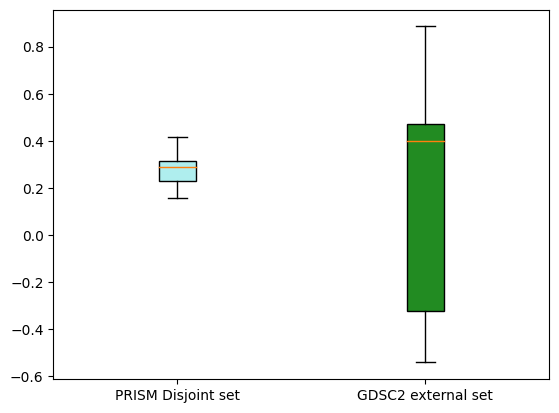

In [126]:
# cell-wise SCC
from scipy.stats import spearmanr
# evaluation result
GDSC_scc_result = []
for cell_line in GDSC_pred.columns:
    tmp_data = GDSC2_external_IC50.loc[GDSC_pred.index, cell_line].dropna()
    tmp_result = GDSC_pred.loc[tmp_data.index, cell_line]

    scc, scc_p = spearmanr(np.array(tmp_data), 1-np.array(tmp_result))
    GDSC_scc_result.append(scc)

# evaluation result
PRISM_scc_result = []
for cell_line in cadrres_svm_pred.columns:
    tmp_data = prism_both.loc[PRISM_pred.index, cell_line].dropna()
    tmp_result = PRISM_pred.loc[tmp_data.index, cell_line]


    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    PRISM_scc_result.append(scc)


print(np.mean(np.array(PRISM_scc_result).flatten()))
print(np.mean(np.array(np.array(GDSC_scc_result)[np.isnan(GDSC_scc_result) == False]).flatten()))

colors_dict={"PRISM Disjoint set": "paleturquoise", "GDSC2 external set": "forestgreen"}

pred_dict = {'PRISM Disjoint set': np.array(PRISM_scc_result),
            'GDSC2 external set': np.array(np.array(GDSC_scc_result)[np.isnan(GDSC_scc_result) == False]).flatten()}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

0.06039072228261301
0.42662417434063254


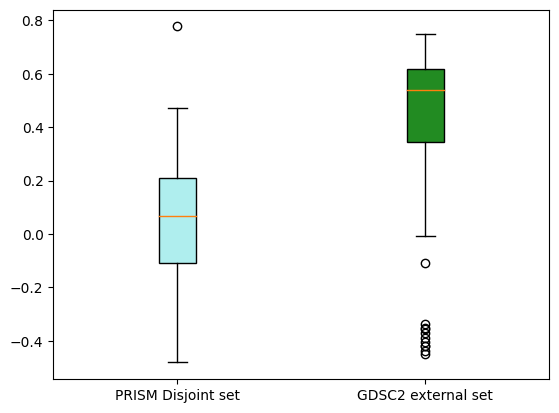

In [128]:
# drug-wise SCC
from scipy.stats import spearmanr
# evaluation result
GDSC_scc_result = []
for smiles in GDSC_pred.index:
    tmp_data = GDSC2_external_IC50.loc[smiles, GDSC_pred.columns].dropna()
    tmp_result = GDSC_pred.loc[smiles, tmp_data.index]

    # ranking
    #label_rank = np.array(tmp_data.rank(axis=0))
    #pred_rank = np.array(tmp_result.rank(axis=0))

    scc, scc_p = spearmanr(np.array(tmp_data), 1-np.array(tmp_result))
    GDSC_scc_result.append(scc)

# evaluation result
PRISM_scc_result = []
for smiles in cadrres_svm_pred.index:
    tmp_data = prism_both.loc[smiles, cadrres_svm_pred.columns].dropna()
    tmp_result = cadrres_svm_pred.loc[smiles, tmp_data.index]

    # ranking
    #label_rank = np.array(tmp_data.rank(axis=0))
    #pred_rank = np.array(tmp_result.rank(axis=0))

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    PRISM_scc_result.append(scc)
PRISM_scc_result = [scc for scc in PRISM_scc_result if np.isnan(scc)==False]

print(np.mean(np.array(PRISM_scc_result).flatten()))
print(np.mean(np.array(np.array(GDSC_scc_result)[np.isnan(GDSC_scc_result) == False]).flatten()))

colors_dict={"PRISM Disjoint set": "paleturquoise", "GDSC2 external set": "forestgreen"}

pred_dict = {'PRISM Disjoint set': np.array(PRISM_scc_result),
            'GDSC2 external set': np.array(np.array(GDSC_scc_result)[np.isnan(GDSC_scc_result) == False]).flatten()}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [3]:
# categories evaluation
## drug wise
### PRISM
from sklearn.metrics import f1_score, accuracy_score, precision_score
prism_f1 = []
prism_precision = []
prism_recall = []
for mol in prism_both.index:
    cl_data = prism_both.loc[mol].dropna().values
    cl_pred = PRISM_pred.loc[mol][prism_both.loc[mol].isna() == False].values
    gt = []
    for val in cl_data:
        if val >= 0.6:
            gt.append("potential")
        elif val <= 0.2:
            gt.append("inacitve")
        else:
            gt.append("unclear")
    pred = []
    for val in cl_pred:
        if val >= 0.6:
            pred.append("potential")
        elif val <= 0.2:
            pred.append("inacitve")
        else:
            pred.append("unclear")
    prism_f1.append(f1_score(gt, pred, average='micro'))
    prism_precision.append(precision_score(gt, pred, average='micro'))
    prism_recall.append(accuracy_score(gt, pred))

### GDSC2 external testing
GDSC_f1 = []
GDSC_precision = []
GDSC_recall = []
for mol in GDSC_pred.index:
    cl_data = 1-(GDSC2_external_auc.loc[mol].dropna().values)
    cl_pred = GDSC_pred.loc[mol][GDSC2_external_auc.loc[mol].isna() == False].values
    gt = []
    for val in cl_data:
        if val >= 0.6:
            gt.append("potential")
        elif val <= 0.2:
            gt.append("inacitve")
        else:
            gt.append("unclear")
    pred = []
    for val in cl_pred:
        if val >= 0.6:
            pred.append("potential")
        elif val <= 0.2:
            pred.append("inacitve")
        else:
            pred.append("unclear")
    GDSC_f1.append(f1_score(gt, pred, average='micro'))
    GDSC_precision.append(precision_score(gt, pred, average='micro'))
    GDSC_recall.append(accuracy_score(gt, pred))

0.6451688654691636
0.3459699028086936


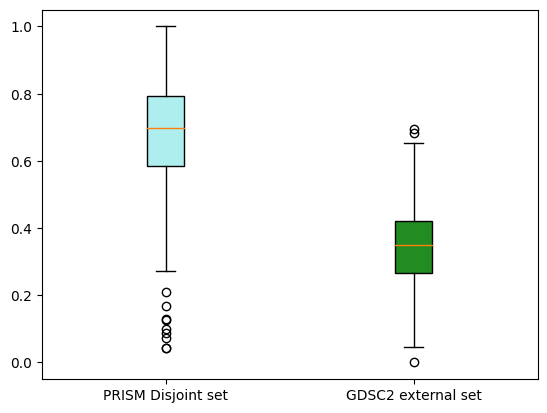

In [5]:
import matplotlib.pyplot as plt
# drug-wise 
print(np.mean(np.array(prism_f1)))
print(np.mean(np.array(GDSC_f1)))
colors_dict={"PRISM Disjoint set": "paleturquoise", "GDSC2 external set": "forestgreen"}

pred_dict = {'PRISM Disjoint set': np.array(prism_f1),
            'GDSC2 external set': np.array(GDSC_f1),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [7]:
## cell-wise
### PRISM disjoint testing
prism_f1 = []
prism_precision = []
prism_recall = []
for cell_line in prism_both.columns:
    cl_data = prism_both[cell_line].dropna().values
    cl_pred = PRISM_pred[cell_line][prism_both[cell_line].isna() == False].values
    gt = []
    for val in cl_data:
        if val >= 0.6:
            gt.append("potential")
        elif val <= 0.2:
            gt.append("inacitve")
        else:
            gt.append("unclear")
    pred = []
    for val in cl_pred:
        if val >= 0.6:
            pred.append("potential")
        elif val <= 0.2:
            pred.append("inacitve")
        else:
            pred.append("unclear")
    prism_f1.append(f1_score(gt, pred, average='micro'))
    prism_precision.append(precision_score(gt, pred, average='micro'))
    prism_recall.append(accuracy_score(gt, pred))

### GDSC2 external testing
from sklearn.metrics import f1_score, accuracy_score, precision_score
GDSC_f1 = []
GDSC_precision = []
GDSC_recall = []
for cell_line in GDSC_pred.columns:
    cl_data = 1-(GDSC2_external_auc[cell_line].dropna().values)
    cl_pred = GDSC_pred[cell_line][GDSC2_external_auc[cell_line].isna() == False].values
    gt = []
    for val in cl_data:
        if val >= 0.6:
            gt.append("potential")
        elif val <= 0.2:
            gt.append("inacitve")
        else:
            gt.append("unclear")
    pred = []
    for val in cl_pred:
        if val >= 0.6:
            pred.append("potential")
        elif val <= 0.2:
            pred.append("inacitve")
        else:
            pred.append("unclear")
    GDSC_f1.append(f1_score(gt, pred, average='micro'))
    GDSC_precision.append(precision_score(gt, pred, average='micro'))
    GDSC_recall.append(accuracy_score(gt, pred))

0.6430204200624036
0.33059906667329475


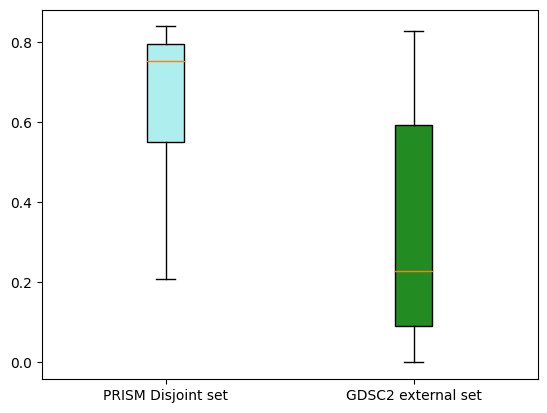

In [8]:
import matplotlib.pyplot as plt
# cell-wise 
print(np.mean(np.array(prism_f1)))
print(np.mean(np.array(GDSC_f1)))
colors_dict={"PRISM Disjoint set": "paleturquoise", "GDSC2 external set": "forestgreen"}

pred_dict = {'PRISM Disjoint set': np.array(prism_f1),
            'GDSC2 external set': np.array(GDSC_f1),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()